# Overall layout of the assignment
Overview: In this assignment you are first going to implement a convolutional graph neural network and then an attention graph neural network by "hand"

Thereafter you are going to implement both using PyTorch Geometric as well as training them on a simple task

# Graph Convoluational Neural Networks

In [1]:
# Installing relevant modules
#!pip install pytorch_lightning



In [2]:
#!pip install networx

In [3]:
# Import relevan libraries
import os
import math
import numpy as np

# Flor plotting
import matplotlib.pyplot as plt
#import seaborn as sns
import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

#torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint



# Graph Convolutions

In [4]:
# Pytorch module for Graph Convolutions
#TASK_Create a class CGNLayer inhereting class nn.Module (imported from Torch)
#__________#
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):                  # c_in : dimension of input feature, c_out : dimension of output feature
        super().__init__()
        #TASK: Add a linear projection for input features
        self.projection = nn.Linear(c_in, c_out) 

    def forward (self, node_feats, adj_matrix):
        '''
        Inputs:
        node_feats = Tensor with node featuers of the shape[batch_size, num_nodes, c_in]
        adj_matrix  = Batch adjecency matrix of the graph - if we are considering self node we will provide 1s on leading Diagonal
        shape:[batch_size, num_nodes, num_nodes]
        '''
    
        # num_neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim =-1, keepdims =True)    # Find nubmer of neighbours needed for normalization
        # TASK: linear projection of the original node features using "self.projection"
        node_feats_transformed = self.projection(node_feats)
        # TASK: Batchwise matrix multiplication with dimensionality (adj_matrix, node_feats)  - since only nodes with featues have a 1 this results in summing over the linearly projected node featues 
        node_feats_aggregated = torch.bmm(adj_matrix, node_feats_transformed)
        # TASK: Normalization (taking into account the number of adjacent nodes)
        node_feats = node_feats_aggregated / num_neighbours.clamp(min=1)
    
        return node_feats

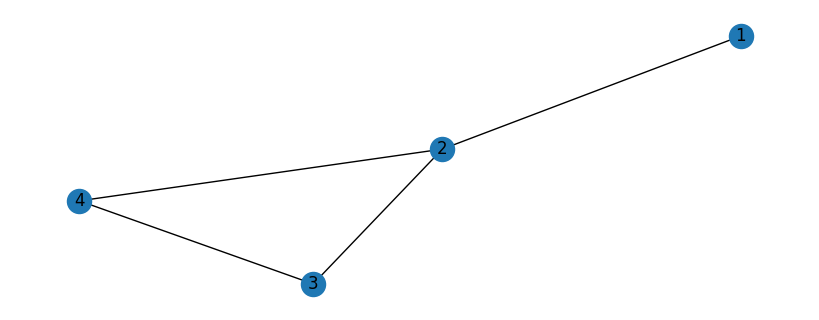

In [5]:
# Let's apply our Convolutional Graph Layer to an example graph
# Creating and plotting a sample graph

import networkx as nx

# creating a graph
nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])   # creates as touples indicating the connections between two nodes 

import matplotlib.pyplot as plt
#nx.draw(g, with_labels=true)
#Plt.show()

fig = plt.figure(figsize = (8,3))
nx.draw(nx_g, with_labels=True)

In [6]:
# Defining nodes featues with torch.arrange

node_feats = torch.arange(8, dtype = torch.float32).view(1,4,2)   # creating some featurs

adj_matrix = torch.Tensor([[[1, 1, 0, 0],     # hand based translation of the graph we saw above (could be done using networkx as well)
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])  # leading diagonal always 1, implying that the self node is also a feature 

print("node featues:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)
                                                      

node featues:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [7]:
# Now let's apply a GCN layer to the graph: for simplicity we inialize the linear weight matrix as identity matrix so that input featues are equal to the message

layer = GCNLayer(c_in=2, c_out=2)   # model

layer.projection.weight.data = torch.Tensor([[1, 0], [0, 1]])
layer.projection.bias.data = torch.Tensor([0, 0])

with torch.no_grad():                       # .no_grad(), since we are doing a simple forward pass
  out_feats = layer(node_feats, adj_matrix) # passingthe features

print("Adjacency matrix", adj_matrix)
print("Input feature", node_feats)
print("Output feaures", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input feature tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output feaures tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


# Graph Attention Neural Network - GAT

In [8]:
class GATLayer(nn.Module):  # inheriting nn.module
  def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
    super().__init__()

    '''Inputs:
          c_in = dimensionality of input features
          c_out = dimensionality of output features

          num_heads = number of heads in attention mechanism  - if bigger > 1 multihead attention
          concat = if True output of all heads will be concatenated instead of averaging
          alpha = negative slope for leaky ReLu
    '''

    
    self.num_heads = num_heads
    self.concat_heads = concat_heads

    if self.concat_heads:               # if we want to concatenate heads instead of taking the average 
      assert c_out % num_heads == 0;    "number of output featues must be the multiple of the count of heads"
      c_out = c_out // num_heads


    # sub module and parameters needed in the layer
    # TASK: create first linear projection ouput whiche depends on number of heads we want attention for
    self.projection = nn.Linear(c_in, c_out * num_heads)
    # TASK:  Initalize weight one weith matrix per head with dimensionality 2*c_out 
    self.a = nn.Parameter(torch.zeros(size=(2 * c_out, num_heads)))
    # TASK: Intialize leaky relu activation with alpha passed as parameter
    self.leakyrelu = nn.LeakyReLU(alpha)

    #Initialization
    nn.init.xavier_uniform_(self.projection.weight.data, gain = 1.414)   # xavier uniform initialization
    nn.init.xavier_uniform_(self.a.data, gain = 1.414)

  def forward(self, node_feats, adj_matrix, print_attn_probs = False):

    batch_size, num_nodes = node_feats.size(0), node_feats.size(1)     # calculating batch size and number of node featues 

    #apply linear layer
    # TASK: Projecting the node features as for GNNs
    node_feats = self.projection(node_feats)
    node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)   # Convert into batch size, number of nodes and number of heads

    # we need to calculate the attention logits for every edge in the adjacency matrix
    # doing this on all possible nodes will be very expensive
    #TASK: return indices where the adjacency matrix is not zero
    edges = adj_matrix.nonzero(as_tuple=False)

    node_feats_flat = node_feats.view(batch_size*num_nodes, self.num_heads, -1)    # Flattening out node features

    edge_indices_row = edges[:, 0] #TASK: Pick the edge indices of the row
    edge_indices_col = edges[:, 1] #TASK:  Pick the edge indices of the column
    
    # Concatenating the features of two nodes
    a_input =torch.cat([
        torch.index_select(input = node_feats_flat, index = edge_indices_row, dim =0),
        torch.index_select(input = node_feats_flat, index = edge_indices_col, dim =0)
    ], dim=-1)   #Index select returns a tensor with node_feats_flat being indexed as the desired position along dim =0 

    # Calculate attention MLP output (independen for each head)
  
    attn_logits = torch.einsum('bhc, hc ->bh', a_input, self.a)  # passing our input a_input and weights self.a
    
    attn_logits = self.leakyrelu(attn_logits) #TASK: apply leaky relu to attention logits

    # Map list of attention values back into matrix
    attn_matrix = attn_logits.new_zeros(adj_matrix.shape + (self.num_heads,)).fill_(-9e15)   # creating matrix with zeros
    attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads)==1] = attn_logits.reshape(-1) # Filling with the attention values for relevant indices

    # Weighted average of attention
    attn_probs = F.softmax(attn_matrix, dim=1) # TASK: pass attn_matrix through softmax
  
    if print_attn_probs:
      print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
    node_feats = torch.einsum('bijh, bjhc -> bihc', attn_probs, node_feats)

    # If heads should be concatenated, we cna do this by reshaping. Otherwise, take the mean
    if self.concat_heads:
      node_feats = node_feats.reshape(batch_size,num_nodes, -1)
    else:
      node_feats = node_feats.mean(dim=2)

    return node_feats

In [9]:
# instantiating the GATNN and doing a forward pass
layer = GATLayer(2,2, num_heads =2, concat_heads=True) 


layer.projection.weight.data = torch.Tensor([[1, 0], [0, 1]])
layer.projection.bias.data = torch.Tensor([0, 0])


layer.a.data = torch.Tensor([[-0.2, 0.3],[0.1,-0.1]])

with torch.no_grad():                       # .no_grad(), since we are doing a simple forward pass
  out_feats = layer(node_feats, adj_matrix, print_attn_probs = False) # passing the features

print("Adjacency matrix", adj_matrix)
print("Input feature", node_feats)
print("Output feaures", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input feature tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output feaures tensor([[[0.1640, 1.3056],
         [1.9270, 5.4154],
         [3.5112, 4.7323],
         [6.3978, 4.5467]]])


# Using Pytorch Geometric

In [10]:
#!pip install torch_geometric

In [11]:
import torch_geometric
import torch_geometric.nn as g_nn
import torch_geometric.data as g_data


## Example of node level task: Semi supervised node classification

A popular example that we will use here is the Cora dataset, a citation network among papers. The Cora dataset consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes. Each publication is represented by a bag-of-words vector. This means that we have a vector of 1433 elements for each publication, where 1 for a feature indicates that the i-th word of a pre-defined dicationary is present in this article.

In [12]:
# Load the dataset and normalized features
from torch_geometric.transforms import NormalizeFeatures 
from torch_geometric.datasets import Planetoid # needed to get the dataset
#TASK: Load troch_geometic dataset "Cora" ind save in "Pytorch_Practice_Models", use  NormalizeFeatures() as transform
dataset = Planetoid(root='./Pytorch_Practice_Models', name='Cora', transform=NormalizeFeatures())

In [13]:
data = dataset[0]
data

# 2708 nodes (publications)
# Every node has 1433 features
# edge indexes show what nodes are connected

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [14]:
# GCN using pytorch-geometric library
from torch_geometric.nn import GCNConv    # Import GCNConv

# TASK: instantiate class GCN as subclass of nn.Module
class GCN(nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234)
    # TASK: set up first convolutional GCN layer  with (dataset.num_features, hidden_channels) as dimensionality
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    # TASK: second convoluational GCN layer (maps to the output ), (hidden_channels, dataset.num_classes) as dimensionality
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
     #TASK: conv 1 layer
    x = self.conv1(x, edge_index)
    #TASK: apply relu activation
    x = F.relu(x)
    #TASK: dropout with p=0.5 
    x = F.dropout(x, p=0.5, training=self.training)
    #TASL:  second conv layer
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels  =16)     # Take 16 hidden channels/ hidden features
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [15]:
model = GCN(hidden_channels = 16)   #instantiating model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay =5e-4) # Adam optimizer with appropriate learning rate and cross entropy loss
criterion = torch.nn.CrossEntropyLoss()  #

def train():
  #TASK: put model in training mode
  model.train()
   #TASK: clear gradients 
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)  #perform a single forward pass 
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes 
  #TASK: derive gradients (backward pass)
  loss.backward()
  #TASK: Update parameters based on gradient
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index) 
  pred = out.argmax(dim=1) # use the class with the highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # check against ground-truth labels
  test_acc = int(test_correct.sum()) /int(data.test_mask.sum())  # Derive ratio of correct predictions
  return test_acc

for epoch in range(1,200):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9461
Epoch: 002, Loss: 1.9414
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9274
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9132
Epoch: 007, Loss: 1.8977
Epoch: 008, Loss: 1.8931
Epoch: 009, Loss: 1.8791
Epoch: 010, Loss: 1.8689
Epoch: 011, Loss: 1.8581
Epoch: 012, Loss: 1.8449
Epoch: 013, Loss: 1.8346
Epoch: 014, Loss: 1.8211
Epoch: 015, Loss: 1.8139
Epoch: 016, Loss: 1.7876
Epoch: 017, Loss: 1.7789
Epoch: 018, Loss: 1.7678
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7218
Epoch: 021, Loss: 1.7238
Epoch: 022, Loss: 1.6986
Epoch: 023, Loss: 1.6777
Epoch: 024, Loss: 1.6534
Epoch: 025, Loss: 1.6534
Epoch: 026, Loss: 1.6279
Epoch: 027, Loss: 1.6144
Epoch: 028, Loss: 1.5818
Epoch: 029, Loss: 1.5823
Epoch: 030, Loss: 1.5491
Epoch: 031, Loss: 1.5195
Epoch: 032, Loss: 1.5177
Epoch: 033, Loss: 1.4970
Epoch: 034, Loss: 1.4455
Epoch: 035, Loss: 1.4448
Epoch: 036, Loss: 1.4392
Epoch: 037, Loss: 1.3998
Epoch: 038, Loss: 1.3734
Epoch: 039, Loss: 1.3814
Epoch: 040, Loss: 1.3734


In [16]:
# Observing performance on test set
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8190


In [17]:
# Geaph Attention Neural Network

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
  def __init__(self, hidden_channels, heads):
    super().__init__()
    torch.manual_seed(1234)
    # TASK: first convolutional GAT layer      (takes the input)
    self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
    # TASK: second convoluational GAT layer (maps to the output )
    self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=heads, concat=False)

  def forward(self, x, edge_index):
    #TASK: dropout p=0.6 use dropout
    x = F.dropout(x, p=0.6, training=self.training)
    #TASK: GAT 1 layer
    x = self.conv1(x, edge_index)
    #TAKS: apply elu activation
    x = F.elu(x)
    #TASK: use dropout, p=0.6
    x = F.dropout(x, p=0.6, training=self.training)
    #TASK apply second GAT layer
    x = self.conv2(x, edge_index)
    return x

model = GAT(hidden_channels  =8, heads=8)     # Take 8 hidden channels/ hidden features and 8 heads
print(model)



GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)


In [18]:
model = GAT(hidden_channels  =8, heads=8)  #instantiating model
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay =5e-4) # Adam optimizer with appropriate learning rate and cross entropy loss
criterion = torch.nn.CrossEntropyLoss()  #

def train():
  # TASK: set model in training mode 
  model.train()
  # TASK:  clear gradients 
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)  #perform a single forward pass 
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes 
  #TASK: derive gradients (backward pass)
  loss.backward()
  #TASK Update parameters based on gradient
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index) 
  pred = out.argmax(dim=1) # use the class with the highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # check against ground-truth labels
  test_acc = int(test_correct.sum()) /int(data.test_mask.sum())  # Derive ratio of correct predictions
  return test_acc

 
for epoch in range(1,200):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9464
Epoch: 002, Loss: 1.9449
Epoch: 003, Loss: 1.9420
Epoch: 004, Loss: 1.9399
Epoch: 005, Loss: 1.9383
Epoch: 006, Loss: 1.9364
Epoch: 007, Loss: 1.9334
Epoch: 008, Loss: 1.9321
Epoch: 009, Loss: 1.9300
Epoch: 010, Loss: 1.9260
Epoch: 011, Loss: 1.9224
Epoch: 012, Loss: 1.9198
Epoch: 013, Loss: 1.9149
Epoch: 014, Loss: 1.9105
Epoch: 015, Loss: 1.9054
Epoch: 016, Loss: 1.9000
Epoch: 017, Loss: 1.8957
Epoch: 018, Loss: 1.8895
Epoch: 019, Loss: 1.8840
Epoch: 020, Loss: 1.8679
Epoch: 021, Loss: 1.8635
Epoch: 022, Loss: 1.8621
Epoch: 023, Loss: 1.8441
Epoch: 024, Loss: 1.8417
Epoch: 025, Loss: 1.8267
Epoch: 026, Loss: 1.8137
Epoch: 027, Loss: 1.8036
Epoch: 028, Loss: 1.7961
Epoch: 029, Loss: 1.7789
Epoch: 030, Loss: 1.7607
Epoch: 031, Loss: 1.7546
Epoch: 032, Loss: 1.7424
Epoch: 033, Loss: 1.7065
Epoch: 034, Loss: 1.6983
Epoch: 035, Loss: 1.6620
Epoch: 036, Loss: 1.6643
Epoch: 037, Loss: 1.6518
Epoch: 038, Loss: 1.6213
Epoch: 039, Loss: 1.6040
Epoch: 040, Loss: 1.5940


In [19]:
# Observing performance on test set
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8170


Summary: in this context and the particular set-up graph convolutions are more effective than graph attention. Propose (argue for), implement and evaluate two potential improvements for the graph attention neural network

### 1. **Deepening the Network Architecture**
**Proposition**: Adding more layers to the GAT can potentially enhance its capability to capture deeper and more complex relational patterns within the graph, a trait often necessary for outperforming convolutional approaches in graphs with highly intricate structures.

**Implementation Details**:
- Implement skip connections (residual learning) between layers to help mitigate the vanishing gradient problem, which is common in deeper networks.
- Use layer normalization to stabilize learning and adaptive learning rate techniques to fine-tune training across deeper architectures.

### 2. **Optimized Use of Multi-Head Attention**
**Proposition**: Enhancing the design and initialization of multi-head attention in GATs can lead to better feature representation and learning. By diversifying the initial states and roles of each attention head, the network can explore and capture a wider array of relationships in the data, potentially overcoming areas where graph convolutions typically excel.

**Implementation Details**:
- Increase the number of attention heads to provide multiple representations of the nodes' features, each focusing on different aspects of the data.
- Diverse initialization of these heads, using orthogonal initialization, to ensure that each head learns distinct, complementary aspects of the data.
- Introduce regularization strategies (Dropout applied selectively on the heads) to prevent overfitting and promote robustness in feature learning.

In [20]:
from torch.nn import LayerNorm
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
        self.norm1 = LayerNorm(hidden_channels * heads)  # Layer normalization
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.6)
        self.norm2 = LayerNorm(hidden_channels * heads)  # Another layer normalization
        self.conv3 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False)  # Output layer
        self.norm3 = LayerNorm(num_classes)  # Normalization for the output layer

        # Skip connection if dimensions are the same
        if hidden_channels * heads == num_features:
            self.skip1 = torch.nn.Identity()
        else:
            self.skip1 = torch.nn.Linear(num_features, hidden_channels * heads)
        
        # Skip connection for second layer
        if hidden_channels * heads == hidden_channels * heads:
            self.skip2 = torch.nn.Identity()
        else:
            self.skip2 = torch.nn.Linear(hidden_channels * heads, hidden_channels * heads)

    def forward(self, x, edge_index):
        # Initial input
        skip1 = self.skip1(x)

        # First GAT layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.norm1(x + skip1)  # Add skip connection after normalization

        # Second GAT layer
        skip2 = self.skip2(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = self.norm2(x + skip2)  # Add skip connection after normalization

        # Output layer
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)  # Normalize output layer features

        return x

# Example initialization
model = GAT(num_features=dataset.num_features, num_classes=dataset.num_classes, hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (conv2): GATConv(64, 8, heads=8)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (conv3): GATConv(64, 7, heads=1)
  (norm3): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
  (skip1): Linear(in_features=1433, out_features=64, bias=True)
  (skip2): Identity()
)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay =5e-4) # Adam optimizer with appropriate learning rate and cross entropy loss
criterion = torch.nn.CrossEntropyLoss()  #

def train():
  # TASK: set model in training mode 
  model.train()
  # TASK:  clear gradients 
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)  #perform a single forward pass 
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes 
  #TASK: derive gradients (backward pass)
  loss.backward()
  #TASK Update parameters based on gradient
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index) 
  pred = out.argmax(dim=1) # use the class with the highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # check against ground-truth labels
  test_acc = int(test_correct.sum()) /int(data.test_mask.sum())  # Derive ratio of correct predictions
  return test_acc

 
for epoch in range(1,200):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 2.4158
Epoch: 002, Loss: 2.1897
Epoch: 003, Loss: 2.0141
Epoch: 004, Loss: 1.8515
Epoch: 005, Loss: 1.7366
Epoch: 006, Loss: 1.7940
Epoch: 007, Loss: 1.5468
Epoch: 008, Loss: 1.3807
Epoch: 009, Loss: 1.2618
Epoch: 010, Loss: 1.0749
Epoch: 011, Loss: 1.0902
Epoch: 012, Loss: 0.9680
Epoch: 013, Loss: 0.9572
Epoch: 014, Loss: 0.8887
Epoch: 015, Loss: 0.8693
Epoch: 016, Loss: 0.7868
Epoch: 017, Loss: 0.8027
Epoch: 018, Loss: 0.7656
Epoch: 019, Loss: 0.7070
Epoch: 020, Loss: 0.7437
Epoch: 021, Loss: 0.7162
Epoch: 022, Loss: 0.6185
Epoch: 023, Loss: 0.6221
Epoch: 024, Loss: 0.5761
Epoch: 025, Loss: 0.5953
Epoch: 026, Loss: 0.5881
Epoch: 027, Loss: 0.6025
Epoch: 028, Loss: 0.5695
Epoch: 029, Loss: 0.5320
Epoch: 030, Loss: 0.5027
Epoch: 031, Loss: 0.4760
Epoch: 032, Loss: 0.4952
Epoch: 033, Loss: 0.4965
Epoch: 034, Loss: 0.5145
Epoch: 035, Loss: 0.4593
Epoch: 036, Loss: 0.4675
Epoch: 037, Loss: 0.4533
Epoch: 038, Loss: 0.4225
Epoch: 039, Loss: 0.4496
Epoch: 040, Loss: 0.4575


In [22]:
# Observing performance on test set
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7780


More layers seem to lead to overfitting, actually decreasing accuracy with a lower loss than before. Let's try the second approach:

In [23]:
from torch.nn.init import orthogonal_
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(12345)

        self.heads = heads
        self.hidden_channels = hidden_channels

        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1, concat=False)  # Output layer

        # Initialize weights differently for each head
        self.initialize_heads()

    def initialize_heads(self):
        # Apply orthogonal or sparse initialization to the weights of each head
        for name, param in self.named_parameters():
            if 'lin_l' in name:  # Target the linear transformation weights in GATConv
                if 'weight' in name:
                    orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, x, edge_index):
        # Apply selective dropout on attention heads' outputs
        x = F.dropout(x, p=0.6, training=self.training)
        x1 = F.elu(self.conv1(x, edge_index))

        # Applying dropout to each head's output before concatenation
        split_x1 = x1.split(self.hidden_channels, dim=1)
        x1 = torch.cat([F.dropout(head, p=0.6, training=self.training) for head in split_x1], dim=1)

        # Again apply dropout selectively for each head
        split_x2 = x1.split(self.hidden_channels, dim=1)
        x2 = torch.cat([F.dropout(head, p=0.6, training=self.training) for head in split_x2], dim=1)

        x3 = self.conv2(x2, edge_index)

        return x3

In [24]:
model = GAT(hidden_channels  =4, heads=28)  #instantiating model with new parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay =5e-4) # Adam optimizer with appropriate learning rate and cross entropy loss
criterion = torch.nn.CrossEntropyLoss()  #

def train():
  # TASK: set model in training mode 
  model.train()
  # TASK:  clear gradients 
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)  #perform a single forward pass 
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) #compute the loss solely based on the training nodes 
  #TASK: derive gradients (backward pass)
  loss.backward()
  #TASK Update parameters based on gradient
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index) 
  pred = out.argmax(dim=1) # use the class with the highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # check against ground-truth labels
  test_acc = int(test_correct.sum()) /int(data.test_mask.sum())  # Derive ratio of correct predictions
  return test_acc

 
for epoch in range(1,200):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9468
Epoch: 002, Loss: 1.9339
Epoch: 003, Loss: 1.9237
Epoch: 004, Loss: 1.9112
Epoch: 005, Loss: 1.9040
Epoch: 006, Loss: 1.8922
Epoch: 007, Loss: 1.8785
Epoch: 008, Loss: 1.8693
Epoch: 009, Loss: 1.8545
Epoch: 010, Loss: 1.8407
Epoch: 011, Loss: 1.8318
Epoch: 012, Loss: 1.8179
Epoch: 013, Loss: 1.7894
Epoch: 014, Loss: 1.7984
Epoch: 015, Loss: 1.7619
Epoch: 016, Loss: 1.7594
Epoch: 017, Loss: 1.7363
Epoch: 018, Loss: 1.7106
Epoch: 019, Loss: 1.6883
Epoch: 020, Loss: 1.6733
Epoch: 021, Loss: 1.6613
Epoch: 022, Loss: 1.6365
Epoch: 023, Loss: 1.6364
Epoch: 024, Loss: 1.5833
Epoch: 025, Loss: 1.5651
Epoch: 026, Loss: 1.5484
Epoch: 027, Loss: 1.5374
Epoch: 028, Loss: 1.4951
Epoch: 029, Loss: 1.4594
Epoch: 030, Loss: 1.4553
Epoch: 031, Loss: 1.4357
Epoch: 032, Loss: 1.4033
Epoch: 033, Loss: 1.4020
Epoch: 034, Loss: 1.3598
Epoch: 035, Loss: 1.3183
Epoch: 036, Loss: 1.3053
Epoch: 037, Loss: 1.3080
Epoch: 038, Loss: 1.2718
Epoch: 039, Loss: 1.2498
Epoch: 040, Loss: 1.2080


In [25]:
# Observing performance on test set
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8230


This is more successful, improving the accuracy closer to the 83.0 ± 0.7% achieved in the original GAT paper on the Cora Benchmark.